In [35]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

os.chdir(r"C:\Users\krish\Downloads\Stats & ML\My projects\Customer Churn - Classification")
os.getcwd()
 
df = pd.read_csv('Telecom_customer churn.csv')
df

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,S,U,U,U,Y,U,Y,773.0,1099996
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,N,U,U,Y,Y,Y,Y,835.0,1099997
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,U,Y,Y,U,U,U,N,433.0,1099998
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,S,U,U,U,U,U,N,75.0,1099999


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

**EDA**

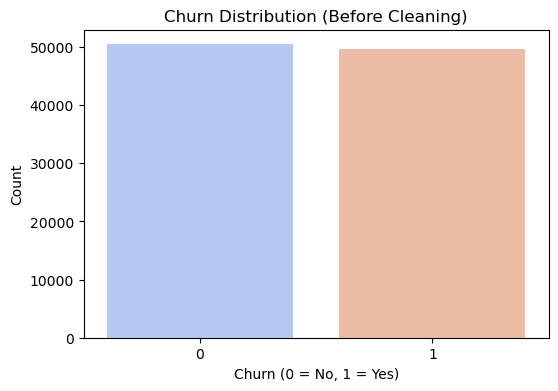

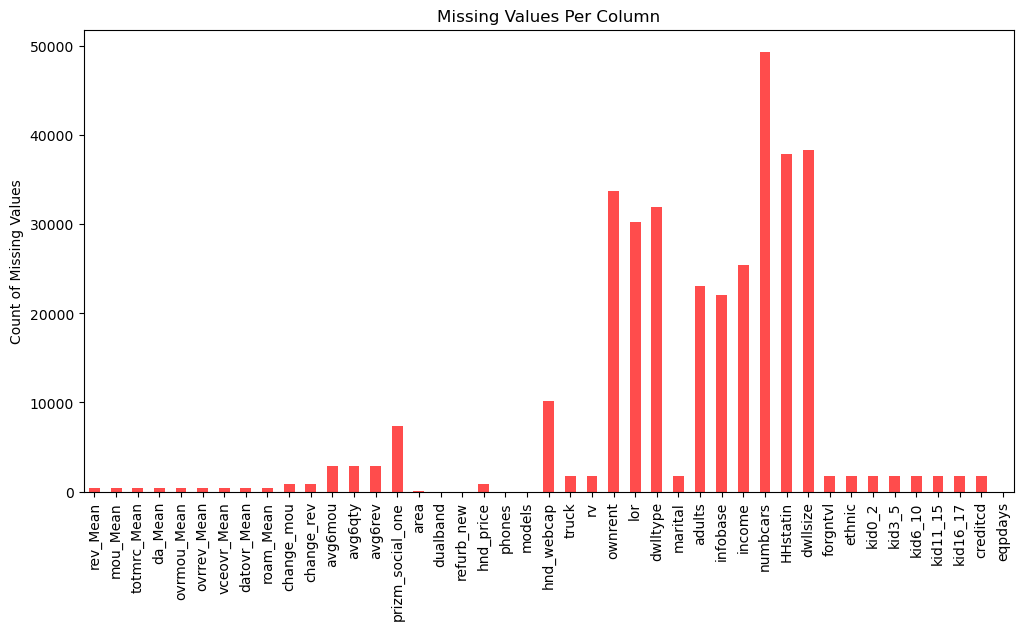

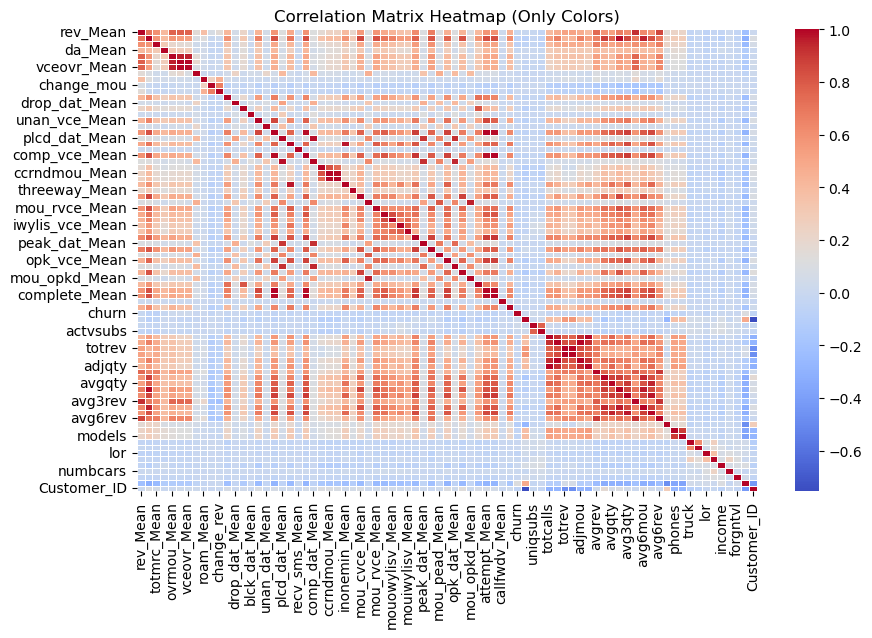

In [38]:
#churn distribution visualized via countplot
plt.figure(figsize=(6, 4))
sns.countplot(x=df["churn"], palette="coolwarm", hue=df["churn"], legend=False)
plt.title("Churn Distribution (Before Cleaning)")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Missing Values per column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  
missing_values.plot(kind='bar', figsize=(12, 6), color='red', alpha=0.7)
plt.title("Missing Values Per Column")
plt.ylabel("Count of Missing Values")
plt.show()

# Heatmap without annotations
correlation_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap (Only Colors)")
plt.show()

**Data Pre-processing**

In [39]:
# Calculate the threshold for dropping columns (more than 30% missing values)

threshold = 0.3 * len(df)
columns_to_drop = [col for col in df.columns if df[col].isnull().sum() > threshold]
clean_df = df.drop(columns=columns_to_drop)
clean_df.describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,hnd_price,phones,models,truck,rv,adults,income,forgntvl,eqpdays,Customer_ID
count,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99109.000000,...,99153.000000,99999.000000,99999.000000,98268.000000,98268.000000,76981.000000,74564.000000,98268.000000,99999.000000,1.000000e+05
mean,58.719985,513.559937,46.179136,0.888828,41.072247,13.559560,13.295062,0.261318,1.286405,-13.933818,...,101.875763,1.787118,1.545825,0.188820,0.082580,2.530326,5.783112,0.057974,391.932309,1.050000e+06
std,46.291677,525.168140,23.623489,2.177619,97.296150,30.500885,30.056089,3.126531,14.711374,276.087509,...,61.005671,1.313977,0.898395,0.391368,0.275248,1.452819,2.182132,0.233696,256.482193,2.886766e+04
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,9.989998,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-5.000000,1.000001e+06
25%,33.260000,150.750000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-87.000000,...,29.989990,1.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000,212.000000,1.025001e+06
50%,48.195000,355.500000,44.990000,0.247500,2.750000,1.000000,0.682500,0.000000,0.000000,-6.250000,...,99.989990,1.000000,1.000000,0.000000,0.000000,2.000000,6.000000,0.000000,342.000000,1.050000e+06
75%,70.750000,703.000000,59.990000,0.990000,42.000000,14.437500,14.025000,0.000000,0.235000,63.000000,...,149.989990,2.000000,2.000000,0.000000,0.000000,3.000000,7.000000,0.000000,530.000000,1.075000e+06
max,3843.262500,12206.750000,409.990000,159.390000,4320.750000,1102.400000,896.087500,423.540000,3685.200000,31219.250000,...,499.989990,28.000000,16.000000,1.000000,1.000000,6.000000,9.000000,1.000000,1823.000000,1.100000e+06


In [40]:
# Using KNN imputation to fill in all the missing values. Initially, the missing values are imputed using median and  K=5 is chosen for KNN model.

df_num = clean_df.select_dtypes(include=['float64', 'int64'])
df_categ = clean_df.select_dtypes(exclude=['float64', 'int64'])
df_median_imputed = df_num.fillna(df_num.median())

knn = NearestNeighbors(n_neighbors=5, n_jobs=-1)
knn.fit(df_median_imputed)

imputed_df = df_median_imputed.copy()  

for col in df_num.columns:
    missing_values = df_num[col].isnull()  
    if missing_values.any():  
        distances, indices = knn.kneighbors(df_median_imputed[missing_values])

        for i, missing_idx in enumerate(df_num[missing_values].index):
            neighbor_values = df_median_imputed.iloc[indices[i], df_num.columns.get_loc(col)]
            imputed_df.at[missing_idx, col] = neighbor_values.mean()

final_df = pd.concat([imputed_df, df_categ], axis=1)
print(final_df.isnull().sum())  
final_df.info()

rev_Mean          0
mou_Mean          0
totmrc_Mean       0
da_Mean           0
ovrmou_Mean       0
               ... 
kid3_5         1732
kid6_10        1732
kid11_15       1732
kid16_17       1732
creditcd       1732
Length: 94, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 94 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          100000 non-null  float64
 1   mou_Mean          100000 non-null  float64
 2   totmrc_Mean       100000 non-null  float64
 3   da_Mean           100000 non-null  float64
 4   ovrmou_Mean       100000 non-null  float64
 5   ovrrev_Mean       100000 non-null  float64
 6   vceovr_Mean       100000 non-null  float64
 7   datovr_Mean       100000 non-null  float64
 8   roam_Mean         100000 non-null  float64
 9   change_mou        100000 non-null  float64
 10  change_rev        100000 non-null  float64
 11  drop_vce_Mean   

In [41]:
# Replacing missing categorical data with equivalent mode values

cat_colns = final_df.select_dtypes(include=['object']).columns
final_df[cat_colns] = final_df[cat_colns].fillna(clean_df[cat_colns].mode().iloc[0])
final_df.info()
print(final_df['churn'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 94 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          100000 non-null  float64
 1   mou_Mean          100000 non-null  float64
 2   totmrc_Mean       100000 non-null  float64
 3   da_Mean           100000 non-null  float64
 4   ovrmou_Mean       100000 non-null  float64
 5   ovrrev_Mean       100000 non-null  float64
 6   vceovr_Mean       100000 non-null  float64
 7   datovr_Mean       100000 non-null  float64
 8   roam_Mean         100000 non-null  float64
 9   change_mou        100000 non-null  float64
 10  change_rev        100000 non-null  float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     100

In [42]:
# creating a copy to use different pre-processing techniques for different instances

df1=final_df.copy()

In [43]:
# Creating a function that will apply InterQuartile range limits for outlier detection . Removing outliers with threshold 3.0 (less stringent).

def IQR(df, threshold=3.0):  
    num_columns = df.select_dtypes(include=['number']).columns.tolist()  

    Q1 = df[num_columns].quantile(0.25)  
    Q3 = df[num_columns].quantile(0.75)  
    IQR = Q3 - Q1  

    lower_bound = Q1 - threshold * IQR  
    upper_bound = Q3 + threshold * IQR  

    df_filtered = df[~((df[num_columns] < lower_bound) | (df[num_columns] > upper_bound)).any(axis=1)].copy()  
    return df_filtered.reset_index(drop=True)

print(f"Original df1 Shape: {final_df.shape}")
print(f"Original df1 Shape: {df1.shape}")
df1 = IQR(df1, threshold=3.0)
final_df = IQR(final_df, threshold=3.0)

# Print new shape
print(f"Filtered df1 Shape: {df1.shape}")
print(f"Filtered df1 Shape: {final_df.shape}")

Original df1 Shape: (100000, 94)
Original df1 Shape: (100000, 94)
Filtered df1 Shape: (34166, 94)
Filtered df1 Shape: (34166, 94)


In [44]:
# Converting the churn column to object type. This is done before PCA.

df1['churn'] = df1['churn'].astype(int)
df1['churn'] = df1['churn'].map({1: 'positive', 0: 'negative'})
df1['churn']

0        positive
1        positive
2        negative
3        negative
4        negative
           ...   
34161    positive
34162    positive
34163    positive
34164    negative
34165    negative
Name: churn, Length: 34166, dtype: object

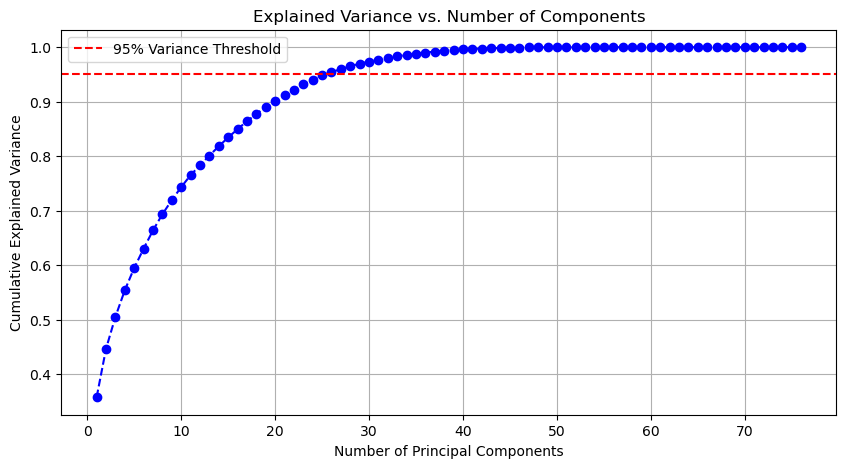

Optimal number of components to retain 95% variance: 26

PCA Loadings (Feature Contributions to Each Principal Component):
      rev_Mean  mou_Mean  totmrc_Mean   da_Mean  ovrmou_Mean  ovrrev_Mean  \
PC1   0.134952  0.180569     0.104254  0.067853     0.090974     0.088273   
PC2   0.106965 -0.041307     0.077326  0.026392     0.003487    -0.000365   
PC3   0.288644  0.108837     0.258400  0.055650     0.179277     0.181955   
PC4   0.074940 -0.055126    -0.156069  0.032210     0.432222     0.435134   
PC5   0.031393 -0.002529     0.037047  0.011933    -0.014984    -0.008575   
PC6   0.213572 -0.091645     0.338580  0.049745    -0.235052    -0.240748   
PC7   0.166405 -0.153069     0.148280  0.041741     0.022628     0.023005   
PC8  -0.005753  0.048448     0.007833 -0.009384    -0.027660    -0.038089   
PC9   0.055398 -0.073710     0.049961 -0.105551     0.011093     0.019222   
PC10  0.001659  0.203754     0.024655 -0.081622     0.021280     0.016714   
PC11  0.046785  0.054786     0

In [45]:
# Standardizing numerical features and appliying PCA to reduce dimensionality while retaining 95% variance. 
# Fixing the optimal number of components, transforming data accordingly, and retains categorical & target variables at the end.  

df_numeric = df1.select_dtypes(include=['float64', 'int64']).drop(columns=['churn'], errors='ignore')  
df_categorical = df1.select_dtypes(exclude=['float64', 'int64'])
df_churn = df1[['churn']] if 'churn' in df1.columns else None

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Applying PCA with all components
pca = PCA(n_components=None)
df_pca = pca.fit_transform(df_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explaining variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.grid()
plt.show()

# Choosing optimal number of components (95% variance)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components to retain 95% variance: {optimal_components}")

pca_final = PCA(n_components=optimal_components)
df_pca_final = pca_final.fit_transform(df_scaled)
pca_loadings = pd.DataFrame(
                            pca_final.components_, columns=df_numeric.columns, index=[f'PC{i+1}' for i in range(optimal_components)])

print("\nPCA Loadings (Feature Contributions to Each Principal Component):")
print(pca_loadings)


df_pca_final = pd.DataFrame(df_pca_final, columns=pca_loadings.index).reset_index(drop=True)
df1 = pd.concat([df_pca_final, df_categorical.reset_index(drop=True)], axis=1)
if df_churn is not None:
    df1 = pd.concat([df1, df_churn.reset_index(drop=True)], axis=1)


print(f"\nOriginal shape: {df_numeric.shape}, PCA transformed shape: {df_pca_final.shape}")
print("\nFinal DataFrame Preview:")
print(df1.head())


In [46]:
# Removing the duplicate 'churn' column

df1 = df1.loc[:, ~df1.columns.duplicated()]
df1.info()
df1["churn"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34166 entries, 0 to 34165
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PC1               34166 non-null  float64
 1   PC2               34166 non-null  float64
 2   PC3               34166 non-null  float64
 3   PC4               34166 non-null  float64
 4   PC5               34166 non-null  float64
 5   PC6               34166 non-null  float64
 6   PC7               34166 non-null  float64
 7   PC8               34166 non-null  float64
 8   PC9               34166 non-null  float64
 9   PC10              34166 non-null  float64
 10  PC11              34166 non-null  float64
 11  PC12              34166 non-null  float64
 12  PC13              34166 non-null  float64
 13  PC14              34166 non-null  float64
 14  PC15              34166 non-null  float64
 15  PC16              34166 non-null  float64
 16  PC17              34166 non-null  float6

0        positive
1        positive
2        negative
3        negative
4        negative
           ...   
34161    positive
34162    positive
34163    positive
34164    negative
34165    negative
Name: churn, Length: 34166, dtype: object

In [47]:
# Converting the colummn back to int. 

df1['churn'] = df1['churn'].map({'positive': 1, 'negative': 0})
df1['churn']
print(df1['churn'].unique())

[1 0]


In [48]:
# Encoding categorical column using label encoder for final_df

label_encoders = {}
for col in cat_colns:
    if col in final_df.columns:  
        le = LabelEncoder()
        final_df[col] = le.fit_transform(final_df[col])  
        label_encoders[col] = le

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34166 entries, 0 to 34165
Data columns (total 94 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev_Mean          34166 non-null  float64
 1   mou_Mean          34166 non-null  float64
 2   totmrc_Mean       34166 non-null  float64
 3   da_Mean           34166 non-null  float64
 4   ovrmou_Mean       34166 non-null  float64
 5   ovrrev_Mean       34166 non-null  float64
 6   vceovr_Mean       34166 non-null  float64
 7   datovr_Mean       34166 non-null  float64
 8   roam_Mean         34166 non-null  float64
 9   change_mou        34166 non-null  float64
 10  change_rev        34166 non-null  float64
 11  drop_vce_Mean     34166 non-null  float64
 12  drop_dat_Mean     34166 non-null  float64
 13  blck_vce_Mean     34166 non-null  float64
 14  blck_dat_Mean     34166 non-null  float64
 15  unan_vce_Mean     34166 non-null  float64
 16  unan_dat_Mean     34166 non-null  float6

In [49]:
# Encoding categorical column using label encoder for df1

label_encoders = {}
for col in cat_colns:
    if col in df1.columns:  
        le = LabelEncoder()
        df1[col] = le.fit_transform(df1[col])  
        label_encoders[col] = le  

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34166 entries, 0 to 34165
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PC1               34166 non-null  float64
 1   PC2               34166 non-null  float64
 2   PC3               34166 non-null  float64
 3   PC4               34166 non-null  float64
 4   PC5               34166 non-null  float64
 5   PC6               34166 non-null  float64
 6   PC7               34166 non-null  float64
 7   PC8               34166 non-null  float64
 8   PC9               34166 non-null  float64
 9   PC10              34166 non-null  float64
 10  PC11              34166 non-null  float64
 11  PC12              34166 non-null  float64
 12  PC13              34166 non-null  float64
 13  PC14              34166 non-null  float64
 14  PC15              34166 non-null  float64
 15  PC16              34166 non-null  float64
 16  PC17              34166 non-null  float6

In [50]:
# Creating a split of data that has been PCA-treated .

X = df1.drop(columns=["churn"])  
y = df1["churn"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\krish\AppData\Local\Temp\ipykernel_8676\3159989871.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_df["churn"], palette="Set1")


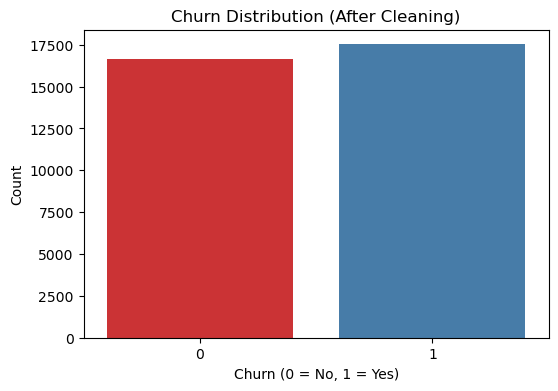

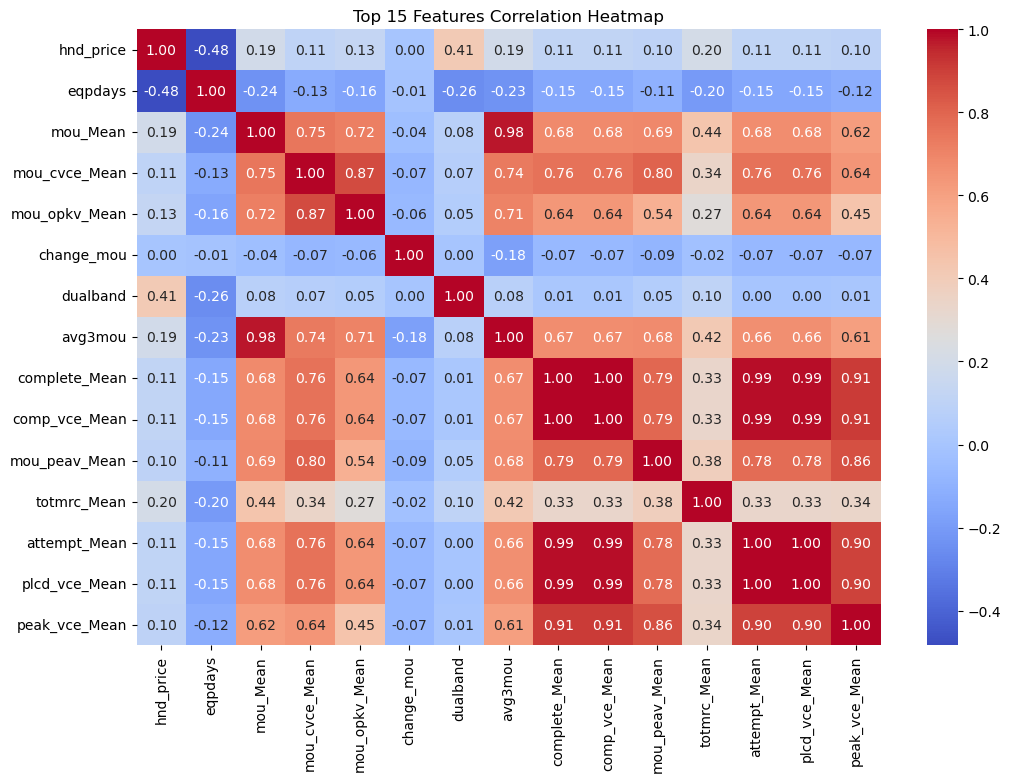

In [51]:
# 1. Churn Distribution (After Cleaning)
plt.figure(figsize=(6, 4))
sns.countplot(x=final_df["churn"], palette="Set1")
plt.title("Churn Distribution (After Cleaning)")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation = final_df.corr()["churn"].abs().sort_values(ascending=False)
top_corr_features = correlation.index[1:16]  # Exclude churn 
sns.heatmap(final_df[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top 15 Features Correlation Heatmap")
plt.show()

In [52]:
# Picking the top 30 features with high correlation with 'churn' from dataset.  Standardizing data for dataframe "final_df".

correlation_matrix = final_df.corr()
target_correlation = correlation_matrix["churn"]
top_corr_features = target_correlation.abs().sort_values(ascending=False)
top_30_features = top_corr_features.index[1:31]  # Excluding 'churn'
print(f"Top 30 features based on correlation with 'churn': \n{top_30_features}")

X_selected = final_df[top_30_features]
y = final_df["churn"]

X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected) 
X_test_selected_scaled = scaler.transform(X_test_selected)

X_train_selected_scaled = pd.DataFrame(X_train_selected_scaled, columns=top_30_features)
X_test_selected_scaled = pd.DataFrame(X_test_selected_scaled, columns=top_30_features)

Top 30 features based on correlation with 'churn': 
Index(['hnd_price', 'eqpdays', 'mou_Mean', 'mou_cvce_Mean', 'mou_opkv_Mean',
       'change_mou', 'dualband', 'avg3mou', 'complete_Mean', 'comp_vce_Mean',
       'mou_peav_Mean', 'totmrc_Mean', 'attempt_Mean', 'plcd_vce_Mean',
       'peak_vce_Mean', 'hnd_webcap', 'mouiwylisv_Mean', 'opk_vce_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'iwylis_vce_Mean', 'Customer_ID',
       'mouowylisv_Mean', 'avg3qty', 'totrev', 'adjrev', 'models', 'asl_flag',
       'totcalls', 'avg6mou'],
      dtype='object')


In [53]:
#Calculating the Variance inflation factor for the top 30 features.

X_train_with_const = add_constant(X_train_selected)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]
print(vif_data)

C:\Barzini\Anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


            Feature           VIF
0             const  3.114100e+03
1         hnd_price  1.671829e+00
2           eqpdays  2.440522e+00
3          mou_Mean  4.684331e+01
4     mou_cvce_Mean  2.312313e+04
5     mou_opkv_Mean  1.485497e+04
6        change_mou  1.985696e+00
7          dualband  1.272873e+00
8           avg3mou  6.734239e+01
9     complete_Mean           inf
10    comp_vce_Mean           inf
11    mou_peav_Mean  1.205749e+04
12      totmrc_Mean  1.841056e+00
13     attempt_Mean           inf
14    plcd_vce_Mean           inf
15    peak_vce_Mean  2.794095e+01
16       hnd_webcap  1.304465e+00
17  mouiwylisv_Mean  4.586538e+00
18     opk_vce_Mean  1.855480e+01
19    mou_rvce_Mean  5.446038e+03
20  owylis_vce_Mean  7.524349e+00
21  iwylis_vce_Mean  5.127498e+00
22      Customer_ID  2.143990e+00
23  mouowylisv_Mean  5.476215e+00
24          avg3qty  1.629604e+01
25           totrev  1.359223e+02
26           adjrev  1.401280e+02
27           models  1.756017e+00
28         asl

In [54]:
# Eliminating features with high multicollinearity (VIF > 5) from training and test sets. Recalculating VIF later to confirm reduction.  

high_vif_features = vif_data[vif_data["VIF"] > 5]["Feature"].tolist()
high_vif_features = [feature for feature in high_vif_features if feature != 'const']

X_train_selected_scaled_reduced = X_train_selected.drop(columns=high_vif_features)
X_test_selected_scaled_reduced = X_test_selected.drop(columns=high_vif_features)

X_train_selected_scaled_with_const_reduced = add_constant(X_train_selected_scaled_reduced)
vif_data_reduced_train = pd.DataFrame()
vif_data_reduced_train["Feature"] = X_train_selected_scaled_with_const_reduced.columns
vif_data_reduced_train["VIF"] = [variance_inflation_factor(X_train_selected_scaled_with_const_reduced.values, i) 
                                  for i in range(X_train_selected_scaled_with_const_reduced.shape[1])]

# Recalculate VIF after feature removal for the test set
X_test_selected_scaled_with_const_reduced = add_constant(X_test_selected_scaled_reduced)
vif_data_reduced_test = pd.DataFrame()
vif_data_reduced_test["Feature"] = X_test_selected_scaled_with_const_reduced.columns
vif_data_reduced_test["VIF"] = [variance_inflation_factor(X_test_selected_scaled_with_const_reduced.values, i) 
                                 for i in range(X_test_selected_scaled_with_const_reduced.shape[1])]

print(f"Remaining features after VIF filtering (Training Set): \n{X_train_selected_scaled_reduced.columns}")
print(f"Recalculated VIF values (Training Set): \n{vif_data_reduced_train}")
print(f"Remaining features after VIF filtering (Test Set): \n{X_test_selected_scaled_reduced.columns}")
print(f"Recalculated VIF values (Test Set): \n{vif_data_reduced_test}")


Remaining features after VIF filtering (Training Set): 
Index(['hnd_price', 'eqpdays', 'change_mou', 'dualband', 'totmrc_Mean',
       'hnd_webcap', 'mouiwylisv_Mean', 'Customer_ID', 'models', 'asl_flag',
       'totcalls'],
      dtype='object')
Recalculated VIF values (Training Set): 
            Feature          VIF
0             const  2685.267320
1         hnd_price     1.656414
2           eqpdays     2.085789
3        change_mou     1.009170
4          dualband     1.258722
5       totmrc_Mean     1.180175
6        hnd_webcap     1.301959
7   mouiwylisv_Mean     1.121640
8       Customer_ID     1.795200
9            models     1.575633
10         asl_flag     1.085550
11         totcalls     1.522539
Remaining features after VIF filtering (Test Set): 
Index(['hnd_price', 'eqpdays', 'change_mou', 'dualband', 'totmrc_Mean',
       'hnd_webcap', 'mouiwylisv_Mean', 'Customer_ID', 'models', 'asl_flag',
       'totcalls'],
      dtype='object')
Recalculated VIF values (Test Set): 
   

In [55]:
X_train_selected_scaled_reduced
X_test_selected_scaled_reduced

,hnd_price,eqpdays,change_mou,dualband,totmrc_Mean,hnd_webcap,mouiwylisv_Mean,Customer_ID,models,asl_flag,totcalls
21299,29.989990,382.0,-10.50,0,39.9900,2,0.000000,1060070,1.0,0,671
10851,99.989990,276.0,-5.25,3,30.0000,2,0.476667,1030513,2.0,0,455
13705,59.989990,511.0,-0.25,3,69.9900,2,0.066667,1037829,1.0,0,544
15977,149.989990,255.0,52.50,3,69.9900,2,1.540000,1044363,3.0,0,2461
26427,59.989990,340.0,-5.50,3,10.0000,2,0.000000,1074537,1.0,0,148
...,...,...,...,...,...,...,...,...,...,...,...
3734,29.989990,708.0,-98.50,0,34.9800,1,1.256667,1011545,2.0,0,5092
19240,149.989990,419.0,16.75,3,10.0000,2,0.000000,1054014,1.0,0,261
1600,9.989998,459.0,-105.50,0,49.9900,2,2.273333,1005248,2.0,0,4386
1806,149.989990,323.0,-10.75,3,29.9900,2,0.000000,1005905,3.0,0,1628


In [63]:

rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],          
    'min_samples_leaf': [3, 5, 10],     
    'min_samples_split': [2, 5, 10],    
    'max_features': ['sqrt', 'log2'],   
    'max_leaf_nodes': [None, 10, 20],   
}


rf_random1 = RandomizedSearchCV(
                                RandomForestClassifier(random_state=42), rf_param_dist, 
                                n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

rf_random1.fit(X_train_selected_scaled_reduced, y_train)
print("Best Parameters for Random Forest:", rf_random1.best_params_)
best_rf1 = rf_random1.best_estimator_

train_score = best_rf1.score(X_train_selected_scaled_reduced, y_train)
rf_preds_tuned1 = best_rf1.predict(X_test_selected_scaled_reduced)
test_score = accuracy_score(y_test, rf_preds_tuned1)

print("\nTuned Random Forest Accuracy on Training Set:", train_score)
print("\nTuned Random Forest Accuracy on Test Set:", test_score)
print("\nTuned Random Forest Classification Report:\n", classification_report(y_test, rf_preds_tuned1))


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 15}

Tuned Random Forest Accuracy on Training Set: 0.7789038489682424

Tuned Random Forest Accuracy on Test Set: 0.6082821188176764

Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.53      0.57      3329
           1       0.60      0.68      0.64      3505

    accuracy                           0.61      6834
   macro avg       0.61      0.61      0.60      6834
weighted avg       0.61      0.61      0.61      6834



In [65]:

rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],          
    'min_samples_leaf': [3, 5, 10],     
    'min_samples_split': [2, 5, 10],    
    'max_features': ['sqrt', 'log2'],   
    'max_leaf_nodes': [None, 10, 20],   
}

rf_random2 = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_dist, 
                               n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

rf_random2.fit(X_train, y_train)
print("Best Parameters for Random Forest:", rf_random2.best_params_)
best_rf2 = rf_random2.best_estimator_

train_score = best_rf2.score(X_train, y_train)
rf_preds_tuned2 = best_rf.predict(X_test)
test_score = accuracy_score(y_test, rf_preds_tuned2)

print("\nTuned Random Forest Accuracy on Training Set:", train_score)
print("\nTuned Random Forest Accuracy on Test Set:", test_score)
print("\nTuned Random Forest Classification Report:\n", classification_report(y_test, rf_preds_tuned2))


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 10, 'max_features': 'log2', 'max_depth': 20}

Tuned Random Forest Accuracy on Training Set: 0.53669691204449

Tuned Random Forest Accuracy on Test Set: 0.5083406496927129

Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.05      0.09      3329
           1       0.51      0.94      0.66      3505

    accuracy                           0.51      6834
   macro avg       0.48      0.50      0.38      6834
weighted avg       0.49      0.51      0.38      6834



In [66]:

rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],          
    'min_samples_leaf': [3, 5, 10],     
    'min_samples_split': [2, 5, 10],    
    'max_features': ['sqrt', 'log2'],   
    'max_leaf_nodes': [None, 10, 20],   
}

rf_random3 = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_dist, 
                               n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

rf_random3.fit(X_train_selected_scaled, y_train)
print("Best Parameters for Random Forest:", rf_random3.best_params_)
best_rf3 = rf_random3.best_estimator_

train_score = best_rf3.score(X_train_selected_scaled, y_train)
rf_preds_best3 = best_rf3.predict(X_test_selected_scaled)
test_score = accuracy_score(y_test, rf_preds_best3)

print("\nTuned Random Forest Accuracy on Training Set:", train_score)
print("\nTuned Random Forest Accuracy on Test Set:", test_score)
print("\nTuned Random Forest Classification Report:\n", classification_report(y_test, rf_preds_best3))


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 15}

Tuned Random Forest Accuracy on Training Set: 0.8267964290941021

Tuned Random Forest Accuracy on Test Set: 0.6151594966344747

Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.53      0.57      3329
           1       0.61      0.69      0.65      3505

    accuracy                           0.62      6834
   macro avg       0.62      0.61      0.61      6834
weighted avg       0.62      0.62      0.61      6834



In [67]:

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],           
    'colsample_bytree': [0.5, 0.7, 1.0],    
    'alpha': [0, 0.1, 0.5],                 
    'lambda': [0, 1, 10],                   
    'gamma': [0, 0.1, 0.5]                  
}

xgb_random1 = RandomizedSearchCV(
                                XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
                                xgb_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)


xgb_random1.fit(X_train_selected_scaled, y_train)
print("Best Parameters for XGBoost:", xgb_random1.best_params_)
best_xgb1 = xgb_random1.best_estimator_

xgb_train_score = best_xgb1.score(X_train_selected_scaled, y_train)
xgb_preds_best1 = best_xgb1.predict(X_test_selected_scaled)
xgb_test_score = accuracy_score(y_test, xgb_preds_best1)

print("\nTuned XGBoost Accuracy on Training Set:", xgb_train_score)
print("\nTuned XGBoost Accuracy on Test Set:", xgb_test_score)
print("\nTuned XGBoost Classification Report:\n", classification_report(y_test, xgb_preds_best1))


C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [01:56:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 0.1}

Tuned XGBoost Accuracy on Training Set: 0.6486901800087809

Tuned XGBoost Accuracy on Test Set: 0.6243781094527363

Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.59      3329
           1       0.62      0.69      0.65      3505

    accuracy                           0.62      6834
   macro avg       0.63      0.62      0.62      6834
weighted avg       0.62      0.62      0.62      6834



In [68]:

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],           
    'colsample_bytree': [0.5, 0.7, 1.0],    
    'alpha': [0, 0.1, 0.5],                 
    'lambda': [0, 1, 10],                   
    'gamma': [0, 0.1, 0.5]                  
}

xgb_random2 = RandomizedSearchCV(
                                XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
                                xgb_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

xgb_random2.fit(X_train, y_train)
print("Best Parameters for XGBoost:", xgb_random2.best_params_)
best_xgb2 = xgb_random2.best_estimator_

xgb_train_score = best_xgb2.score(X_train, y_train)
xgb_preds_tuned2 = best_xgb2.predict(X_test)
xgb_test_score = accuracy_score(y_test, xgb_preds_tuned2)

print("\nTuned XGBoost Accuracy on Training Set:", xgb_train_score)
print("\nTuned XGBoost Accuracy on Test Set:", xgb_test_score)
print("\nTuned XGBoost Classification Report:\n", classification_report(y_test, xgb_preds_tuned2))


C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [01:56:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'lambda': 10, 'gamma': 0, 'colsample_bytree': 0.7, 'alpha': 0.5}

Tuned XGBoost Accuracy on Training Set: 0.5287940875164642

Tuned XGBoost Accuracy on Test Set: 0.5146327187591454

Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.05      0.09      3329
           1       0.51      0.95      0.67      3505

    accuracy                           0.51      6834
   macro avg       0.52      0.50      0.38      6834
weighted avg       0.52      0.51      0.39      6834



In [69]:

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],           
    'colsample_bytree': [0.5, 0.7, 1.0],    
    'alpha': [0, 0.1, 0.5],                 
    'lambda': [0, 1, 10],                   
    'gamma': [0, 0.1, 0.5]                  
}

xgb_random3 = RandomizedSearchCV(
                                XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
                                xgb_param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

xgb_random3.fit(X_train_selected_scaled_reduced, y_train)
print("Best Parameters for XGBoost:", xgb_random3.best_params_)
best_xgb3 = xgb_random3.best_estimator_

xgb_train_score = best_xgb3.score(X_train_selected_scaled_reduced, y_train)
xgb_preds_tuned3 = best_xgb3.predict(X_test_selected_scaled_reduced)
xgb_test_score = accuracy_score(y_test, xgb_preds_tuned3)

print("\nTuned XGBoost Accuracy on Training Set:", xgb_train_score)
print("\nTuned XGBoost Accuracy on Test Set:", xgb_test_score)
print("\nTuned XGBoost Classification Report:\n", classification_report(y_test, xgb_preds_tuned3))


C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [01:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 0.1}

Tuned XGBoost Accuracy on Training Set: 0.6334333382116201

Tuned XGBoost Accuracy on Test Set: 0.610769681006731

Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.52      0.57      3329
           1       0.61      0.69      0.65      3505

    accuracy                           0.61      6834
   macro avg       0.61      0.61      0.61      6834
weighted avg       0.61      0.61      0.61      6834



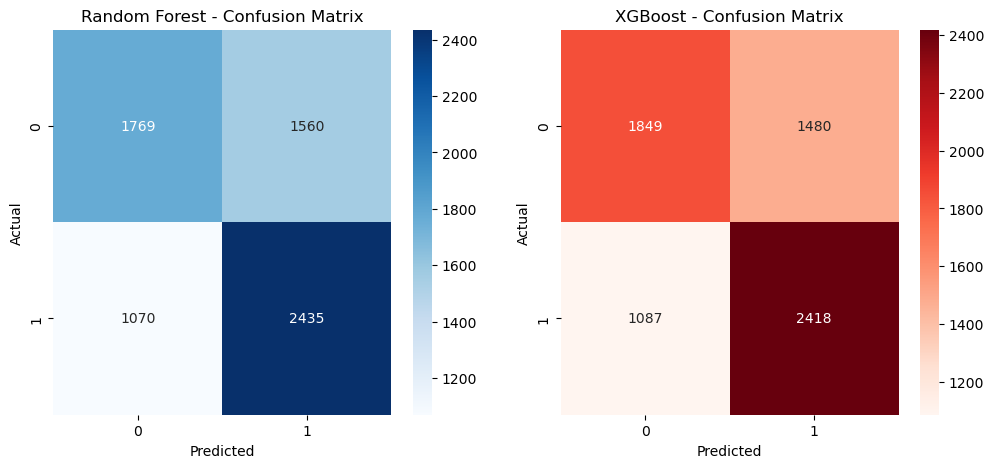

In [62]:
# Confusion Matrices for models with best results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_preds_best3), annot=True, fmt='d', cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, xgb_preds_best1), annot=True, fmt='d', cmap="Reds")
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

###########################################################################################################################################
